# Chicago Divvy Bike Ride-Sharing Analysis

![alt text](images/divvy.jpg)
![alt_text](images/divvy_map.jpg)

### Introduction
This notebook is based on the [Divvy Ride-Sharing Kaggle dataset and competition](https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data) for Divvy bike rides in Chicago, IL. It's a re-creation of a program I created about a year ago that was lost when a hard drive died and I've since learned my lesson so this is going straight to git. Some of the features of the previous program will be implemented but I really want to try to divide the notebooks more atomically so that each serves a pretty specific purpose and doesn't have too large of scope. 

### Goals of the Notebook
 * Conditionally split dataset
 * Determine which stations are busiest/where they usually lead to
 * Show distributions of the data, branch out with Seaborn library
 * Map rides using Basemap--really improve my skills with that
 * Perform machine learning and create models using Scikit-Learn
 

### Importing 
Just a typical data science library stack for the EDA notebook.

In [99]:
import random

import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(15, 15)})

### CSV File Exploration and Importing

The first thing we'll do is peer into the csv files provided by Kaggle to see what kind of data we're looking at. Since the data is incredibly large (don't have a week for operating on 9 million divvy bike rides), for this stage of the analysis we'll just take a random sampling from the data.

To randomize the import I'm just going to retrieve every 1/n lines from the file. 

In [100]:
!wc data/data.csv
!wc data/data_raw.csv

 9495236 105797302 2084674565 data/data.csv
 13774716 160096066 3483195736 data/data_raw.csv


In [145]:
n = 200

csv_filename = 'data/data.csv'
num_lines = sum(1 for l in open(csv_filename))

skip_ix = [x for x in range(1, num_lines) if x % n != 0]

data_df = pd.read_csv(
    csv_filename,
    skiprows=skip_ix
)

print('There are {} rows in the dataset'.format(data_df.shape[0]))

print("Columns in List: \n")
for column in list(data_df):
    print(column)

There are 47476 rows in the dataset
Columns in List: 

trip_id
year
month
week
day
hour
usertype
gender
starttime
stoptime
tripduration
temperature
events
from_station_id
from_station_name
latitude_start
longitude_start
dpcapacity_start
to_station_id
to_station_name
latitude_end
longitude_end
dpcapacity_end


In [102]:
data_df.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2354584,2014,6,27,0,19,Subscriber,Male,2014-06-30 19:07:00,2014-06-30 19:16:00,...,195,Columbus Dr & Randolph St,41.884728,-87.619521,31.0,195,Columbus Dr & Randolph St,41.884728,-87.619521,31.0
1,2354219,2014,6,27,0,18,Subscriber,Male,2014-06-30 18:37:00,2014-06-30 18:41:00,...,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15.0,146,Loomis St & Jackson Blvd,41.877945,-87.662007,11.0
2,2353848,2014,6,27,0,18,Subscriber,Male,2014-06-30 18:16:00,2014-06-30 18:24:00,...,164,Franklin St & Lake St,41.885837,-87.635500,23.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0
3,2353571,2014,6,27,0,17,Subscriber,Female,2014-06-30 17:59:00,2014-06-30 18:07:00,...,264,Stetson Ave & South Water St,41.886835,-87.622320,19.0,181,LaSalle St & Illinois St,41.890749,-87.632060,31.0
4,2353212,2014,6,27,0,17,Subscriber,Male,2014-06-30 17:47:00,2014-06-30 17:52:00,...,51,Clark St & Randolph St,41.884576,-87.631890,31.0,43,Michigan Ave & Washington St,41.883893,-87.624649,43.0


In [103]:
data_df.describe()

,trip_id,year,month,week,day,hour,tripduration,temperature,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end
count,4.747600e+04,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000
mean,9.861332e+06,2015.737362,7.161155,29.380276,2.687105,13.631709,11.430441,62.997397,179.379371,41.900323,-87.644674,21.396327,179.954335,41.900843,-87.644877,21.262722
std,4.680123e+06,1.075635,2.708518,11.779838,1.890231,4.853731,7.193561,17.201051,121.002382,0.034420,0.021597,7.642586,121.792600,0.034713,0.021605,7.563923
min,1.109555e+06,2014.000000,1.000000,1.000000,0.000000,0.000000,2.000000,-9.900000,2.000000,41.736646,-87.802870,0.000000,2.000000,41.736646,-87.802870,0.000000
25%,5.941868e+06,2015.000000,5.000000,21.000000,1.000000,9.000000,6.016667,52.000000,77.000000,41.881032,-87.654752,15.000000,77.000000,41.881320,-87.654787,15.000000
50%,1.005833e+07,2016.000000,7.000000,30.000000,3.000000,15.000000,9.633333,66.900000,164.000000,41.892278,-87.641066,19.000000,164.000000,41.893882,-87.641066,19.000000
75%,1.383274e+07,2017.000000,9.000000,38.000000,4.000000,17.000000,15.133333,75.900000,268.000000,41.920195,-87.630585,23.000000,272.000000,41.921750,-87.630585,23.000000
max,1.753639e+07,2017.000000,12.000000,53.000000,6.000000,23.000000,60.000000,95.000000,625.000000,42.064313,-87.549386,55.000000,625.000000,42.064313,-87.549386,55.000000


**Thoughts:** There are a few really interesting features contained within the dataset that I'll want to explore moving foward in this notebook. I'll break the features down sort of categorically here.

**Geographical:**
 * from_station_id
 * from_station_name
 * latitude_start
 * longitude_start
 * to_station_id
 * to_station_name
 * latitude_end
 * longitude_end
 
**Weather:**
 * temperature
 * events
 
**Datetime:**
 * year
 * month
 * week
 * day
 * hour
 * starttime
 * stoptime
 * tripduration
 
**User-Specific:**
 * usertype
 * gender

### Feature Engineering

There are a couple of columns that we can build from our current set of features.

In [146]:
from numpy import cos, sin, arcsin, sqrt
from math import radians

def haversine(row):
    lon1 = row['longitude_start']
    lat1 = row['latitude_start']
    lon2 = row['longitude_end']
    lat2 = row['latitude_end']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6367 * c
    return km

data_df['displacement'] = data_df.apply(lambda row: haversine(row), axis=1)

#data_df['lat_travel'] = abs(data_df['latitude_end'].sub(data_df['latitude_start']))
#data_df['lon_travel'] = abs(data_df['longitude_end'].sub(data_df['longitude_start']))
#data_df['displacement'] = (data_df['lon_travel'].pow(2) + data_df['lat_travel'].pow(2)).pow(0.5)

In [147]:
data_df.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end,displacement
0,2354584,2014,6,27,0,19,Subscriber,Male,2014-06-30 19:07:00,2014-06-30 19:16:00,...,Columbus Dr & Randolph St,41.884728,-87.619521,31.0,195,Columbus Dr & Randolph St,41.884728,-87.619521,31.0,0.000000
1,2354219,2014,6,27,0,18,Subscriber,Male,2014-06-30 18:37:00,2014-06-30 18:41:00,...,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15.0,146,Loomis St & Jackson Blvd,41.877945,-87.662007,11.0,0.597845
2,2353848,2014,6,27,0,18,Subscriber,Male,2014-06-30 18:16:00,2014-06-30 18:24:00,...,Franklin St & Lake St,41.885837,-87.635500,23.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,1.474809
3,2353571,2014,6,27,0,17,Subscriber,Female,2014-06-30 17:59:00,2014-06-30 18:07:00,...,Stetson Ave & South Water St,41.886835,-87.622320,19.0,181,LaSalle St & Illinois St,41.890749,-87.632060,31.0,0.915650
4,2353212,2014,6,27,0,17,Subscriber,Male,2014-06-30 17:47:00,2014-06-30 17:52:00,...,Clark St & Randolph St,41.884576,-87.631890,31.0,43,Michigan Ave & Washington St,41.883893,-87.624649,43.0,0.603840


In [148]:
data_df.describe()

,trip_id,year,month,week,day,hour,tripduration,temperature,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end,displacement
count,4.747600e+04,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000,47476.000000
mean,9.861332e+06,2015.737362,7.161155,29.380276,2.687105,13.631709,11.430441,62.997397,179.379371,41.900323,-87.644674,21.396327,179.954335,41.900843,-87.644877,21.262722,1.933328
std,4.680123e+06,1.075635,2.708518,11.779838,1.890231,4.853731,7.193561,17.201051,121.002382,0.034420,0.021597,7.642586,121.792600,0.034713,0.021605,7.563923,1.409040
min,1.109555e+06,2014.000000,1.000000,1.000000,0.000000,0.000000,2.000000,-9.900000,2.000000,41.736646,-87.802870,0.000000,2.000000,41.736646,-87.802870,0.000000,0.000000
25%,5.941868e+06,2015.000000,5.000000,21.000000,1.000000,9.000000,6.016667,52.000000,77.000000,41.881032,-87.654752,15.000000,77.000000,41.881320,-87.654787,15.000000,0.924391
50%,1.005833e+07,2016.000000,7.000000,30.000000,3.000000,15.000000,9.633333,66.900000,164.000000,41.892278,-87.641066,19.000000,164.000000,41.893882,-87.641066,19.000000,1.513847
75%,1.383274e+07,2017.000000,9.000000,38.000000,4.000000,17.000000,15.133333,75.900000,268.000000,41.920195,-87.630585,23.000000,272.000000,41.921750,-87.630585,23.000000,2.517615
max,1.753639e+07,2017.000000,12.000000,53.000000,6.000000,23.000000,60.000000,95.000000,625.000000,42.064313,-87.549386,55.000000,625.000000,42.064313,-87.549386,55.000000,14.559222


## General Data Distribution

In [122]:
num_df = data_df.drop(
    [
        'trip_id', 
        'usertype',
        'events',
        'from_station_id',
        'from_station_name',
        'to_station_id',
        'to_station_name',
        'dpcapacity_start',
        'dpcapacity_end'
    ], axis=1
)

In [123]:
if n >= 1000:
    sns.pairplot(num_df)
else:
    print('Not plotting to save time')

Not plotting to save time


### Thoughts:
* Divvy popularity grew over the course of data collection
* People like riding bikes in the summer
* People take bikes to and from work (9AM and 5PM)
* People don't like to ride bikes for more than about 10 minutes
* People like riding bikes when it's about 70 degrees out
* People seem to ride north more than south
* People seem to ride east more than west

In [107]:
if n >= 1000:
    g = sns.PairGrid(num_df)
    g.map_diag(sns.kdeplot)
    g.map_offdiag(sns.kdeplot, n_levels=6)
else:
    print('Not plotting to save time')

Not plotting to save time


### Weather Analysis

**Vanilla Distributions**

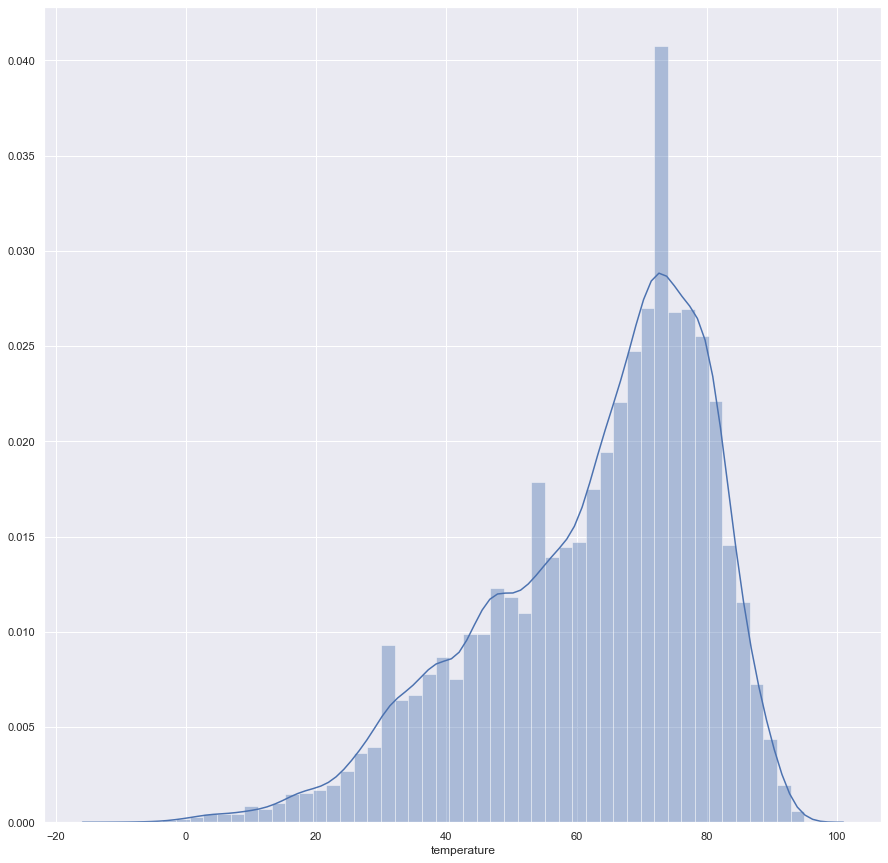

In [108]:
sns.distplot(
    data_df.temperature
)

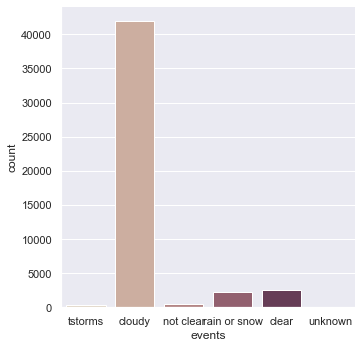

In [109]:
sns.catplot(
    x='events',
    data=data_df,
    kind='count',
    palette='ch:.25'
)

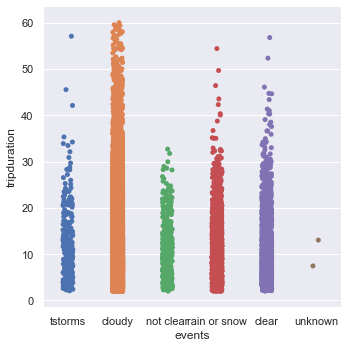

In [110]:
sns.catplot(
    x='events',
    y='tripduration',
    data=data_df
)

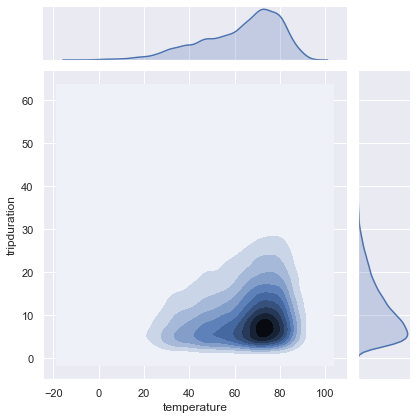

In [111]:
sns.jointplot(
    data_df['temperature'], 
    data_df['tripduration'],
    kind='kde'
)

**Conditional Splitting**

In [112]:
hot_rides  = data_df[data_df['temperature'] > 80]
cold_rides = data_df[data_df['temperature'] < 10]

80.1    1290
82.0    1110
81.0    1024
82.9     743
84.0     676
84.9     672
86.0     478
87.1     381
88.0     323
89.1     234
90.0     201
91.0     114
91.9      80
82.4      37
80.6      31
84.2      29
93.0      27
93.9      24
87.8      21
95.0       6
Name: temperature, dtype: int64


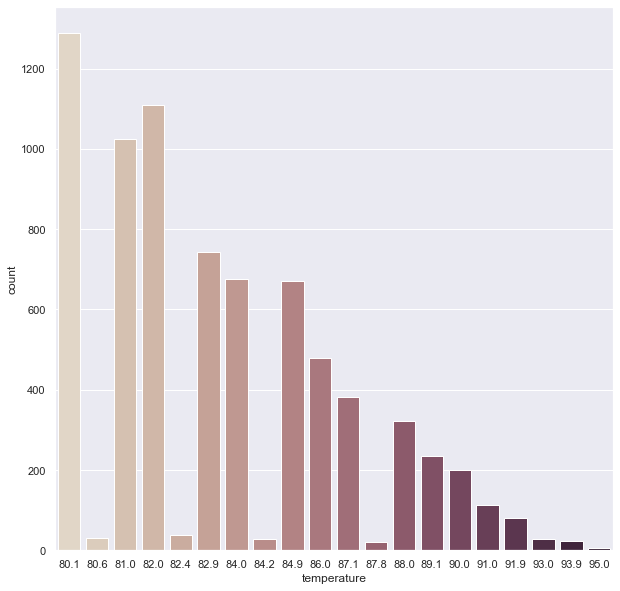

In [113]:
fig, ax = plt.subplots(figsize=(10,10))
sns.catplot(
    x='temperature',
    data=hot_rides,
    kind='count',
    palette='ch:.25',
    ax=ax
)
print(hot_rides['temperature'].value_counts())
plt.close(2)
plt.show()

 9.0    30
 5.0    24
 3.9    23
 7.0    22
 8.1    19
 3.0    18
 6.1    18
 1.9    16
-0.0    11
 1.0     9
-2.0     7
-0.9     6
-6.0     3
-2.9     3
-5.1     2
 8.6     2
 6.8     1
-9.9     1
 3.2     1
Name: temperature, dtype: int64


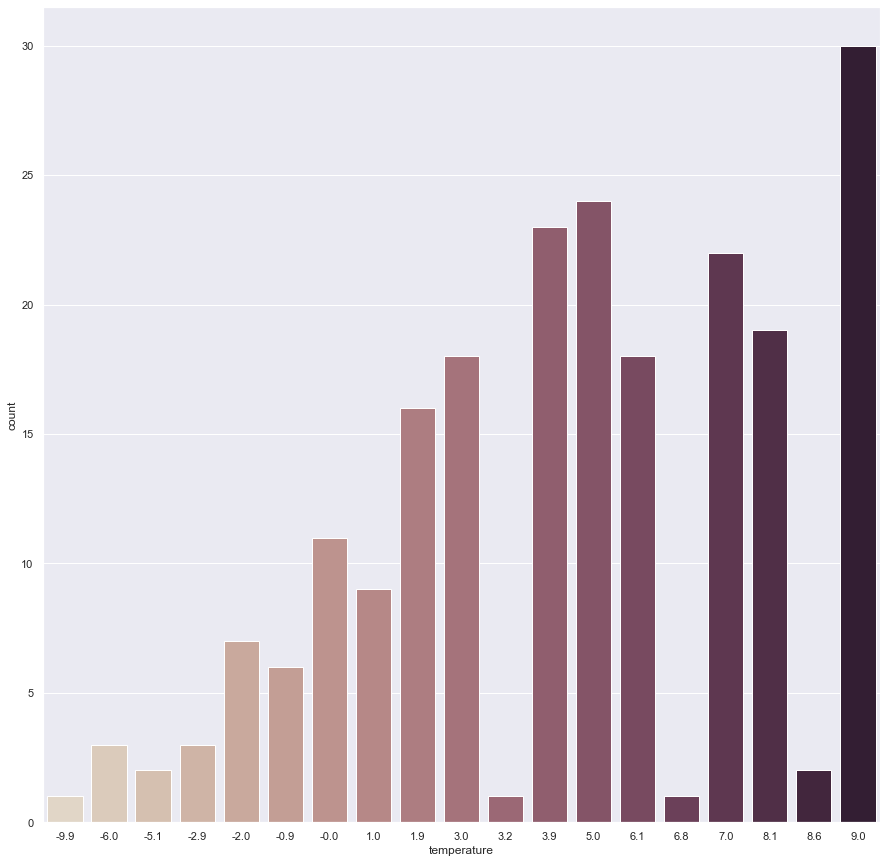

In [114]:
fig, ax = plt.subplots(figsize=(15,15))
sns.catplot(
    x='temperature',
    data=cold_rides,
    kind='count',
    palette='ch:.25',
    ax=ax
)
print(cold_rides['temperature'].value_counts())
plt.close(2)
plt.show()

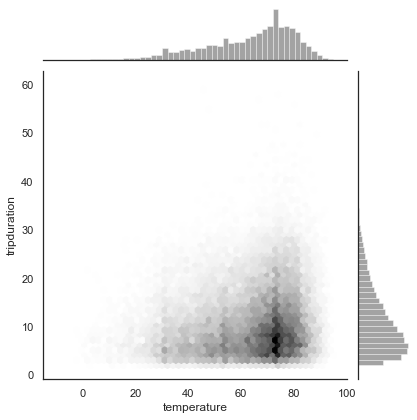

In [115]:
with sns.axes_style("white"):
    sns.jointplot(
        x=data_df['temperature'], 
        y=data_df['tripduration'], 
        kind="hex", 
        color="k",
    )

### Distance Analysis

**Vanilla Distributions**

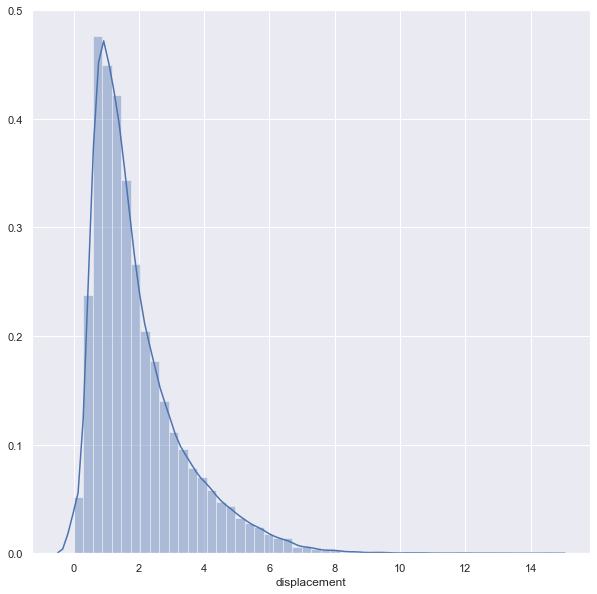

In [149]:
fig, ax = plt.subplots(figsize=(10,10))

sns.distplot(data_df.displacement, ax=ax)

plt.show()

In [ ]:
sns.catplot(
    x='events',
    y='displacement',
    data=data_df
)